### How has spending on specific ASU job descriptions changed over time?

In [1]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns

# read each CSV file into dataframe
FY2012 = pd.read_csv("Data/ASU Employee Salary Data 2012-2017 - The State Press - 2012.csv") 
FY2013 = pd.read_csv("Data/ASU Employee Salary Data 2012-2017 - The State Press - 2013.csv") 
FY2014 = pd.read_csv("Data/ASU Employee Salary Data 2012-2017 - The State Press - 2014.csv") 
FY2015 = pd.read_csv("Data/ASU Employee Salary Data 2012-2017 - The State Press - 2015.csv") 
FY2016 = pd.read_csv("Data/ASU Employee Salary Data 2012-2017 - The State Press - 2016.csv") 
FY2017 = pd.read_csv("Data/ASU Employee Salary Data 2012-2017 - The State Press - 2017.csv") 
FY2018 = pd.read_csv("Data/ASU Employee Salary Data 2012-2017 - The State Press - 2018.csv") 

# simple way of combining the CSV file dataframes into one
# similar to Union operator in SQL
asu_dept_data_long = pd.concat([FY2012,\
                           FY2013,\
                           FY2014,\
                           FY2015,\
                           FY2016,\
                           FY2017,\
                           FY2018])

asu_dept_data_long.drop('Unnamed: 6', axis=1, inplace=True)

# remove characters that prevent numbers from being converted to type int
asu_dept_data_long['Salary'] = asu_dept_data_long['Salary'].str.replace('$','')
asu_dept_data_long['Salary'] = asu_dept_data_long['Salary'].str.replace(',','')

asu_dept_data_long['Salary'] = asu_dept_data_long['Salary'].apply(lambda x: int(float(x)))

In [2]:
asu_dept_data_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71453 entries, 0 to 11773
Data columns (total 6 columns):
Calendar Year             71453 non-null int64
Full Name                 71453 non-null object
Job Description           71453 non-null object
Department Description    71453 non-null object
Salary                    71453 non-null int64
FTE                       71453 non-null float64
dtypes: float64(1), int64(2), object(3)
memory usage: 3.8+ MB


In [3]:
#remove unnecessary column on the right stating where the data came from
asu_dept_data_long.head()

,Calendar Year,Full Name,Job Description,Department Description,Salary,FTE
0,2012,"Aarestad,Barbara",Coordinator,Career Preparation,41000,1.0
1,2012,"Abbas,James",Assoc Professor,Sch Biological & Hlth Sys Engr,96936,1.0
2,2012,"Abbaszadegan,Morteza",Professor,Sch Sustain Engr & Built Envrn,125413,1.0
3,2012,"Abbe,Scott",Tech Support Analyst Coord,Engineering Technical Services,78838,1.0
4,2012,"Abbey,Craig",Director,EVPP Consultant Group,52000,0.5


In [4]:
#verify all years are included
asu_dept_data_long.groupby('Calendar Year')['Calendar Year'].count()

Calendar Year
2012     8778
2013     9172
2014     9677
2015    10321
2016    10709
2017    11022
2018    11774
Name: Calendar Year, dtype: int64

### All positions graphed cumulatively over time

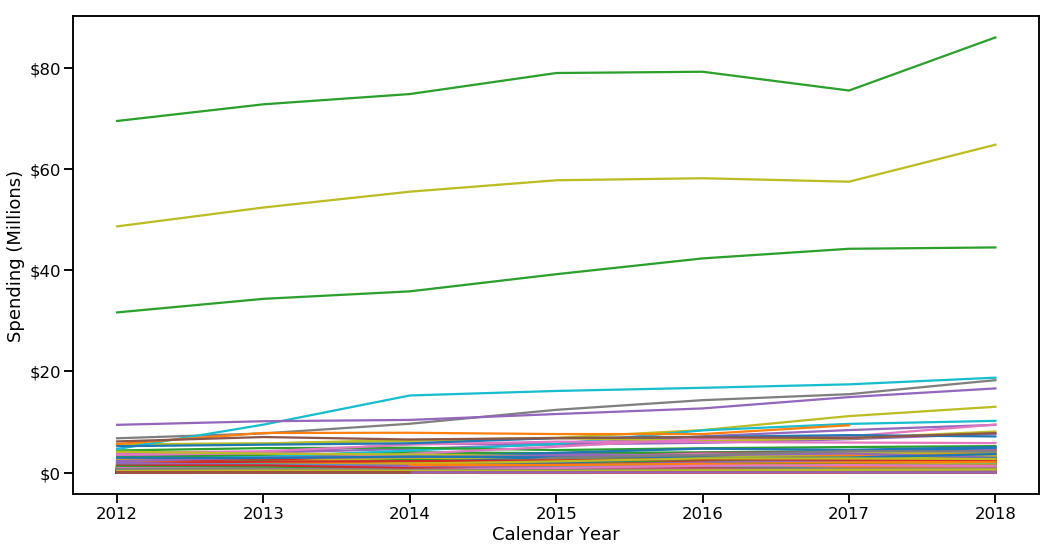

In [170]:
asu_job_group = asu_dept_data_long.groupby(['Calendar Year', 'Job Description'])['Salary'].sum().unstack()
asu_job_group = asu_job_group/1000000

sns.set_context("talk")


fig, ax = plt.subplots(figsize=(15,8))
asu_job_group.plot(ax=ax)
ax.get_legend().remove()

# plt.title("ASU Job Description Salary Spending Over Time")
# plt.xlabel("Year")
plt.ylabel("Spending (Millions)")
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.StrMethodFormatter('${x:,g}'))

plt.tight_layout()

plt.savefig('visualizations/all_job_descriptions.png')

### But what if I want to focus on just the top 5 positions by spending?

In [184]:
top_jobs = asu_dept_data_long.groupby(['Job Description'])['Salary'] \
    .sum() \
    .sort_values(ascending=False) \
    .to_frame() \
    .head(10)

top_jobs

,Salary
Job Description,
Professor,536715186
Assoc Professor,394755003
Asst Professor,272045629
Instructor,98447120
Lecturer,85796192
Director,84637374
Academic Success Specialist,57025474
Regents Professor,48152337
Postdoc Rsrch Assoc FSC 2008,45928948


In [185]:
top_jobs_subset = pd.merge(top_jobs.index.to_frame(), asu_dept_data_long, on='Job Description')
top_jobs_subset.shape

(20135, 6)

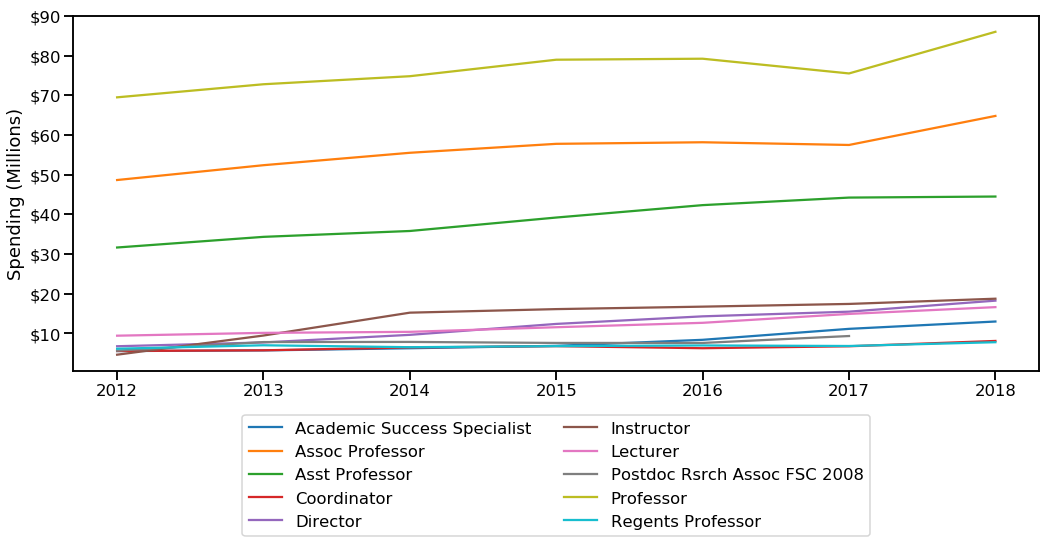

In [188]:
asu_job_group = top_jobs_subset.groupby(['Calendar Year', 'Job Description'])['Salary'].sum().unstack()
asu_job_group = asu_job_group/1000000

sns.set_context("talk")

fig, ax = plt.subplots(figsize=(15,8))
asu_job_group.plot(ax=ax)

# plt.title("ASU Job Description Salary Spending Over Time",fontsize=16)
plt.xlabel("", labelpad=15)
plt.ylabel("Spending (Millions)")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=2)

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.StrMethodFormatter('${x:,g}'))
# great resource for how to adjust the legend outside of the chart
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
plt.tight_layout()

plt.savefig('visualizations/top10_job_description_salary.png')

### How do the mean salaries for the top 5 job descriptions by total spend compare?

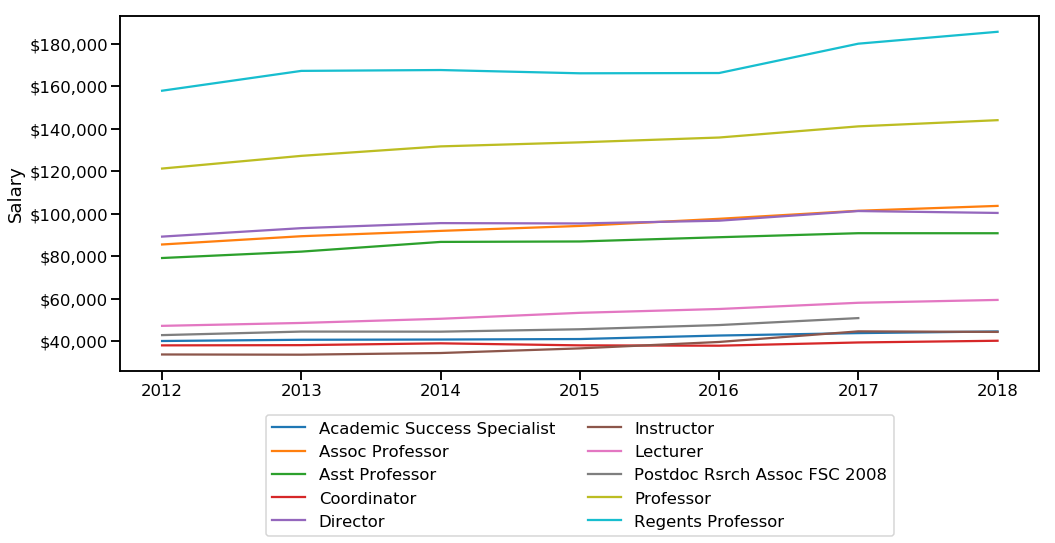

In [189]:
asu_job_group = top_jobs_subset.groupby(['Calendar Year', 'Job Description'])['Salary'].mean().unstack()

sns.set_context("talk")

fig, ax = plt.subplots(figsize=(15,8))
asu_job_group.plot(ax=ax)

# plt.title("ASU Job Description Mean Salaries Over Time",fontsize=16)
plt.xlabel("")
plt.ylabel("Salary")

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),ncol=2)
plt.tight_layout()

plt.savefig('visualizations/top10_job_description_mean_salary.png')

### How do mean salaries compare between the top 10 departments by total department spending?

In [136]:
# find the top 10 departments by spending in 2018

top_10_depts_2018 = asu_dept_data_long[asu_dept_data_long['Calendar Year'] == 2015] \
    .groupby(['Department Description'])['Salary'] \
    .sum() \
    .sort_values(ascending=False) \
    .head(10) \
    .to_frame()

top_10_depts_2018

,Salary
Department Description,
SDA Administration,21200219
Sols Administration & Faculty,12411477
College of Law,12193691
Sch Elect Comptr & Energy Engr,11831193
School Of Earth & Space Explor,11143427
English,10894452
Sch Engr Matter Trnsprt Energy,10315201
School of Math & Stat Sciences,10171341
Sch Compt Infor & Dec Sys Engr,10062106


In [96]:
asu_dept_data_long.head()

,Calendar Year,Full Name,Job Description,Department Description,Salary,FTE
0,2012,"Aarestad,Barbara",Coordinator,Career Preparation,41000,1.0
1,2012,"Abbas,James",Assoc Professor,Sch Biological & Hlth Sys Engr,96936,1.0
2,2012,"Abbaszadegan,Morteza",Professor,Sch Sustain Engr & Built Envrn,125413,1.0
3,2012,"Abbe,Scott",Tech Support Analyst Coord,Engineering Technical Services,78838,1.0
4,2012,"Abbey,Craig",Director,EVPP Consultant Group,52000,0.5


In [153]:
mean_jobs_top_departments = asu_dept_data_long[asu_dept_data_long['Department Description'] \
    .isin(asu_dept_data_long[asu_dept_data_long['Calendar Year'] == 2018] \
        .groupby(['Department Description'])['Salary'] \
        .sum() \
        .sort_values(ascending=False) \
        .head(10).index)]

mean_jobs_top_departments.shape

(9746, 6)

In [ ]:
# Years 2012 - 2015 have a lowercase 'of' in name "College of Law"
# while years 2016 - 2018 have an uppercase 'Of'
# I need to update all years date into a standard format

asu_dept_data_long['Department Description'] = asu_dept_data_long['Department Description'].str.replace('College of Law', 'College Of Law')

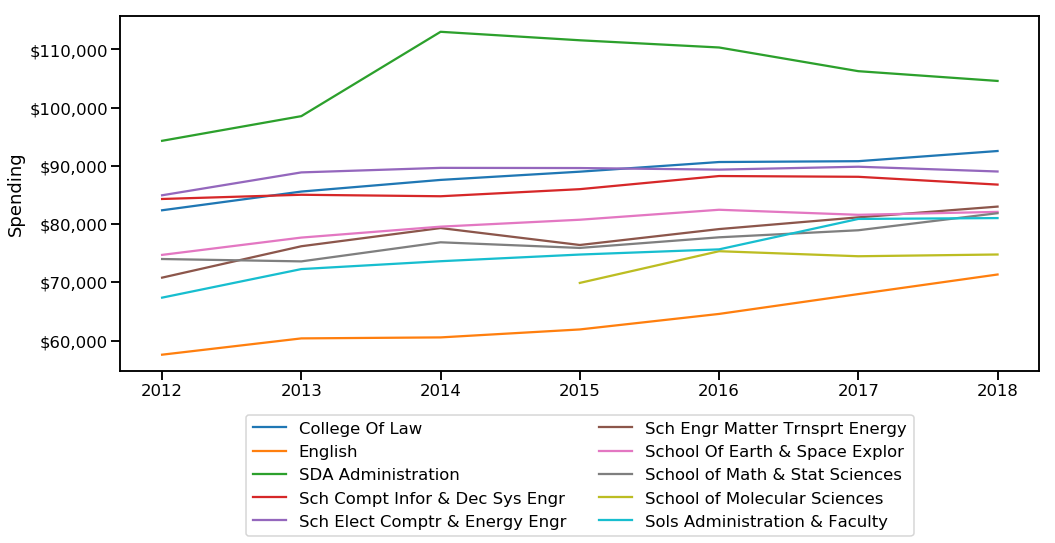

In [160]:
fig, ax = plt.subplots(figsize=(15,8))
mean_jobs_top_departments.groupby(['Calendar Year', 'Department Description'])['Salary'].mean().unstack().plot(ax=ax)

sns.set_context("talk")

# plt.title("Mean ASU Department Salary Spending Over Time",fontsize=16)
plt.xlabel("")
plt.ylabel("Spending")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10000))
plt.tight_layout()

plt.savefig('visualizations/top5_mean_salary.png')